## This is the script is to test one single cross-correlation experiment
## The wiring setup to be used is seen here: https://blogs.zhinst.com/jithesh/files/2020/05/figure2-e1589970333493.png
## This entire script will generate a square and triangle wave, and then acquire these signals by triggering. These waves will then be cross-correlated (in frequency domain) and plotted

In [1]:
# -*- coding: utf-8 -*-
"""
Zurich Instruments Cross-correlation of a square and saw-tooth wave. Demonstrates one single cross-correlation measurement.

Author: J Srinivas
"""

from __future__ import print_function
import time
import numpy as np
import zhinst.utils
import matplotlib.pyplot as plt
from datetime import datetime
import textwrap

## Set the device ID of your UHFLI here! ##
device_id = 'dev2521' 


scope_length=2**18 # the number of samples to acquire: 262,144
scope_time = 2 # scope time of 2 is a sampling rate of 450 MHz

apilevel_example = 6  # The API level supported by this example.
required_devtype = r'UHF'  # Regular expression of supported instruments.
required_options = {}  # No special options required.
required_err_msg = "This example is only compatible with the UHF instrument: " + \
                   "This is designed specifically for UHF-LI, but can be run on UHFQA."
(daq, device, props) = zhinst.utils.create_api_session(device_id, apilevel_example,
                                                       required_devtype=required_devtype,
                                                       required_options=required_options,
                                                       required_err_msg=required_err_msg)
zhinst.utils.api_server_version_check(daq)

# Create a base configuration: Disable all available outputs, awgs, demods, scopes,...
zhinst.utils.api_server_version_check(daq) # Check API versions
daq.setDebugLevel(3) # Enable the API's log.
zhinst.utils.disable_everything(daq, device) # Reset all config/parameters of device


# Define the AWG program, as a string, which synthesizes and plays a square and triangle wave
awg_program = textwrap.dedent("""\
            wave tri = join(zeros(5000),ramp(5000, 1, 0), zeros(5000));
            wave sqr = join(zeros(5000), rect(5000, 1), zeros(5000));

            playWave(tri, sqr, AWG_RATE_28MHZ);

            wait(40032); // Waits a delay before triggering acquisition

            setTrigger(1);
            setTrigger(0);

            waitWave();
        """)


# Create an instance of the AWG Module
awgModule = daq.awgModule()
awgModule.set('device', device)
awgModule.execute()

#Get clockbase
clockbase = daq.getInt('/{}/clockbase'.format(device_id))
# Now configure the instrument for this experiment.

exp_setting = [
    # The output and inputs parameters signal 1.
    ['/%s/sigouts/%d/on'             % (device, 0), 1],
    ['/%s/sigouts/%d/range'          % (device, 0), 1.5],
    ['/%s/sigins/%d/imp50'           % (device, 0), 1],
    
    # The output and inputs parameters signal 1.
    ['/%s/sigouts/%d/on'             % (device, 1), 1],
    ['/%s/sigouts/%d/range'          % (device, 1), 1.5],
    ['/%s/sigins/%d/imp50'           % (device, 1), 1]]

node_branches = daq.listNodes('/{}/'.format(device), 0)
    
daq.set(exp_setting)

# Perform a global synchronisation between the device and the data server:
# Ensure that the signal input and output configuration has taken effect
# before calculating the signal input autorange.
daq.sync()

####################################################################################################################
# Configure the scope and obtain data
####################################################################################################################

# 'length' : the length to capture of acquired data
daq.setInt('/%s/scopes/0/length' % device, scope_length)

# Turns on both channel 1 & 2 of the scope
daq.setInt('/%s/scopes/0/channel' % device, 3)

# Bandwidth limit set for both-channels to avoid anti-aliasing effects
daq.setInt('/%s/scopes/0/channels/%d/bwlimit' % (device, 0), 1)
daq.setInt('/%s/scopes/0/channels/%d/bwlimit' % (device, 1), 1)

# 'channels/0/inputselect' : the input channel for the scope:
#   0 - signal input 1
#   1 - signal input 2
daq.setInt('/%s/scopes/0/channels/%d/inputselect' % (device, 0), 0)
daq.setInt('/%s/scopes/0/channels/%d/inputselect' % (device, 1), 1)

# Sets the sampling rate of the scope
daq.setInt('/%s/scopes/0/time' % device, scope_time)

#   Sets to acquire only one scope shot
daq.setInt('/%s/scopes/0/single' % device, 1)

# Enable trigger
daq.setInt('/%s/scopes/0/trigenable' % device, 1)

# Set trigger to AWG Trigger 1 (192)
daq.setInt('/%s/scopes/0/trigchannel' % device, 192)

# 'segments/enable' : Disable segmented data recording.
daq.setInt('/%s/scopes/0/segments/enable' % device, 0)

daq.sync()

# Now initialize and configure the Scope Module.
scopeModule = daq.scopeModule()

scopeModule.set('mode', 1)

# 'historylength' : The number of scope records to keep in the Scope Module's memory, when more records
#   arrive in the Module from the device the oldest records are overwritten.
scopeModule.set('historylength', 1)

# Subscribe to the scope's data in the module.
wave_nodepath = '/{}/scopes/0/wave'.format(device)
scopeModule.subscribe(wave_nodepath)

########## AWG ##########
# Create an instance of the AWG module
awgModule = daq.awgModule()
awgModule.set('device', device)
awgModule.set('index', 0)
daq.setInt('/dev2521/awgs/0/time', scope_time) # Set Sampling Rate for AWG 
awgModule.execute()

# Tell the module to be ready to acquire data; reset the module's progress to 0.0.
scopeModule.execute()

# Start the scope
daq.setInt('/%s/scopes/0/enable' % device, 1)
daq.sync()
time.sleep(1.0)

# Start the AWG
daq.set([['/' + device + '/awgs/0/single', 1],
             ['/' + device + '/awgs/0/enable', 1]])
daq.sync()

start = time.time()
# Wait until the Scope Module has received and processed the desired number of records.
records = 0 # tracks num. of records acquired
while (records < 1) or (progress < 1.0):
    # Start the AWG
    daq.set([['/' + device + '/awgs/0/single', 1],
                 ['/' + device + '/awgs/0/enable', 1]])
    daq.sync()
    records = scopeModule.getInt("records")
    progress = scopeModule.progress()[0]

    if (time.time() - start) > 30: # The value 30 in seconds repressents time before program terminates if no records are captured
        # Break out of the loop if for some reason we're no longer receiving scope data from the device.
        print("\nScope Module did not return {} records after {} s - forcing stop.".format(num_records, timeout))
        break

    # Read data
    data_time = scopeModule.read(True)

assert wave_nodepath in data_time, "The Scope Module did not return data for {}.".format(wave_nodepath)
print('Number of scope records with triggering enabled: {}.'.format(len(data_time[wave_nodepath])))

# Stop the module
scopeModule.finish()

Discovered device `dev2521`: UHFLI with options MF, PID, MOD, AWG, DIG, BOX, CNT.
Creating an API session for device `dev2521` on `127.0.0.1`, `8004` with apilevel `6`.


C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\zhinst\utils.py:168: UserWarning: There is a mismatch between the versions of the API and Data Server. The API reports version `20.01' (revision: 200101211) whilst the Data Server has version `20.03' (revision 200301386). See the ``Compatibility'' Section in the LabOne Programming Manual for more information.
  warnings.warn(message)


Number of scope records with triggering enabled: 1.


## Let's plot and see the data we have captured in our channels now!

[Text(0, 0.5, 'Signal amplitude /V'), Text(0.5, 0, 'Time /$u$s')]

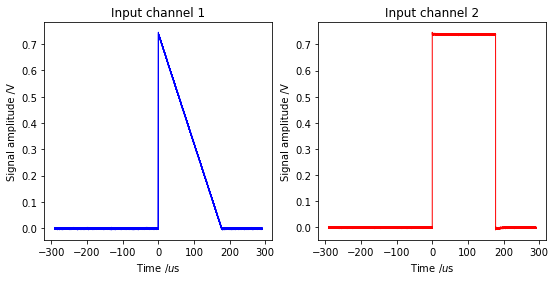

In [2]:
# Find convert the timestamps to the relative time captured in the scope
dt = data_time[wave_nodepath][0][0]['dt']
totalsamples = data_time[wave_nodepath][0][0]['totalsamples']
timestamp = data_time[wave_nodepath][0][0]['timestamp']
triggerTimestamp = data_time[wave_nodepath][0][0]['triggertimestamp']
xtime = np.linspace(0, dt*totalsamples, totalsamples) # This is the time starting from 0
relativeTime = xtime - (timestamp - triggerTimestamp)/float(clockbase) # This is the time as actually captured in scope

# Now extract the waves acquired from the scope module for both channels
wave1 = data_time[wave_nodepath][0][0]['wave'][0]
wave2 = data_time[wave_nodepath][0][0]['wave'][1]

# Let's plot and create two figures for each channel
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))

# We convert time from unit seconds to microseconds
ax1.plot(relativeTime*1000000, wave1,color='blue', linewidth=1)
ax1.set_title('Input channel 1') 
ax1.set(xlabel='Time /$u$s', ylabel='Signal amplitude /V')

ax2.plot(relativeTime*1000000, wave2,color='red', linewidth=1)
ax2.set_title('Input channel 2') 
ax2.set(xlabel='Time /$u$s', ylabel='Signal amplitude /V')

# Now we finally perform cross-correlation! 
## We take the complex conjugate of wave 2 first

In [3]:
# Data array will store both wave arrays
data = [wave1, wave2]

# Let's also see how long it takes to perform cross-correlation here...
start = time.time()

# Convert from time-domain to frequency-domain by applying FFT (scipy module required)
data_fft_0 = np.fft.fft(data[0], len(wave1)*2-1) #fft of channel 1
data_fft_1 = np.fft.fft(data[1], len(wave2)*2-1) #fft of channel 2

# Calculate cross-correlated FFT signal
corr_fft = np.multiply(data_fft_0, np.conj(data_fft_1))

# Cross-correlated time-domain signal
icorr_fft = np.fft.ifft(corr_fft)

# Inverse shift our signal to have zero-component at the center of spectrum
shiftedxcorr = np.fft.fftshift(icorr_fft)

print(f'Total time taken for cross-correlation in the frequency domain: {round(time.time() - start, 2)} seconds')

Total time taken for cross-correlation in the frequency domain: 0.66 seconds


## Cross-correlate again but now with the complex conjugate of wave 1

In [4]:
# Calculate cross-correlated FFT signal with data_fft_0 taken as complex conjugate
corr_fft2 = np.multiply(np.conj(data_fft_0), data_fft_1)

# Cross-correlated time-domain signal
icorr_fft2 = np.fft.ifft(corr_fft2)

# Inverse shift our signal to have zero-component at the center of spectrum
shiftedxcorr2 = np.fft.fftshift(icorr_fft2)

# Additionally, multiplying two FFT signals and inverse-FFT gives us 2x the signal length.
shiftedTime = np.linspace(min(relativeTime), max(relativeTime), len(relativeTime)*2-1)

## Now plot both the cross-correlated results in both cases of complex conjugate taken

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[Text(0, 0.5, 'Normalized result'), Text(0.5, 0, 'Time /$u$s')]

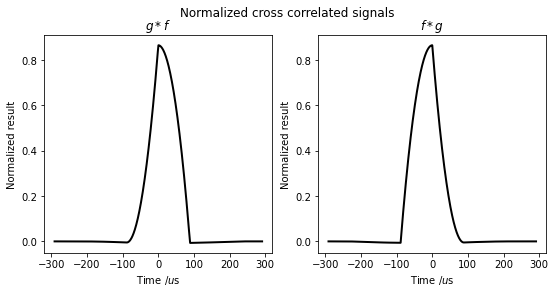

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
fig.suptitle('Normalized cross correlated signals')
# We convert time from unit seconds to microseconds
ax1.plot(shiftedTime*1000000, shiftedxcorr2/np.sqrt(sum(abs(wave1)**2)*sum(abs(wave2)**2)),color='black', linewidth=2)
ax1.set_title('$g * f$') 
ax1.set(xlabel='Time /$u$s', ylabel='Normalized result')

ax2.plot(shiftedTime*1000000, shiftedxcorr/np.sqrt(sum(wave1**2)*sum(wave2**2)),color='black', linewidth=2)
ax2.set_title('$f * g$') 
ax2.set(xlabel='Time /$u$s', ylabel='Normalized result')

# Bonus: what happens when we cross-correlate directly in the time-domain instead? 
#### The time taken is much longer than done in the frequency domain. Frequency domain is a simple dot product multiplication of two arrays (keep in mind, we don't bother normalizing here).

Total time taken for cross correlation in the time-domain: 18.02 seconds


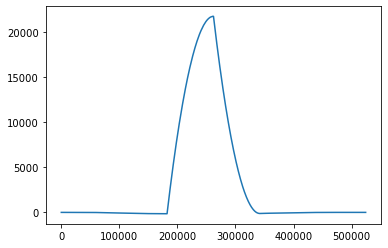

In [6]:
from scipy import signal
start = time.time()
timeCorr = signal.correlate(wave1, wave2, mode = 'full', method='direct')
plt.plot(timeCorr)
print(f'Total time taken for cross correlation in the time-domain: {round(time.time() - start, 2)} seconds')